In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小

In [2]:
def hand_col(df,col ="发动机转速",n=240):
    
    ####计算col停顿时间
    df["last_notna_time"] = df[df[col].notna()].Time   ##当时不是na的时间
    df_notna_time = df[df[col].notna()].Time
    df_notna_time_diff = (df_notna_time - df_notna_time.shift(1)).dt.total_seconds()
    df["last_notna_time_diff"] = df_notna_time_diff
    df["last_notna_time_diff"] = df["last_notna_time_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
    return df

In [3]:
def cz(df,idx,col="累计油耗"):
    num = len(idx)
    for i in range(num-1):
        start = idx.iloc[i]
        end = idx.iloc[i+1]
        cz_num = end-start
        start_num = df.loc[start,col]
        end_num = df.loc[end,col]
        fillna = np.linspace(start_num,end_num,cz_num+1)
        df.loc[start:end,col] = fillna
    return df

In [4]:
def hand_col_cz(df,col ="累计油耗"):   ###插值处理
    
    ####计算col停顿间隔
    df["last_notna_idx"] = df[df[col].notna()].idx   ##当时不是na的idx
    df_notna_idx = df[df[col].notna()].idx
    df_notna_idx_diff = (df_notna_idx - df_notna_idx.shift(1))
    df["last_notna_idx_diff"] = df_notna_idx_diff
    df["last_notna_idx_diff"] = df["last_notna_idx_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
    return df

In [5]:
def hand(df):
    df = df.drop(["GPS纬度","GPS经度","GPS定位时间"],axis=1)#去除无用数据
    df["Time"] = pd.to_datetime(df["time"].str[:-3])#时间转化,直接去掉小数部分
    
    ####停机以发动机数据为准,处理缺失发动机转数
    df = hand_col(df,col ="发动机转速",n=240)
    
    df = hand_col(df,col ="系统压力",n=240)
    
    df = hand_col(df,col ="转向次数",n=240)
    
    df = hand_col(df,col ="泵送排量",n=240)
    
    df = hand_col(df,col ="泵车状态",n=120)
    
    ####油耗单独填充,插值
    df_notna_idx = df[df["累计油耗"].notna()].idx
    df = cz(df,df_notna_idx,col="累计油耗")
    ###
    
    
    ####泵送计时填充
    df["累计时间"] = df["累计时间"].fillna(method = "ffill")
    
    
    
    ####液压油温用插值
    df_notna_idx = df[df["液压油温"].notna()].idx
    df = cz(df,df_notna_idx,col="液压油温")
    return df
    
    
  

In [6]:
df = pd.read_csv("data.csv",skiprows=1)
df["Time"] = pd.to_datetime(df["time"].str[:-3])#时间转化,直接去掉小数部分
df["idx"] = np.arange(len(df))

In [7]:
df = hand(df)

In [8]:
df = df.dropna()

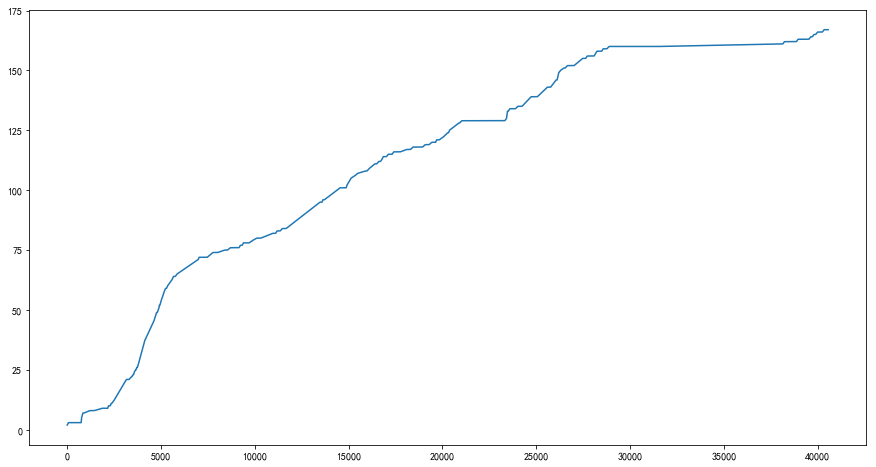

In [81]:
df["累计油耗"].plot()

# 生成时间序列

In [10]:
df["second"] = df.Time.apply(lambda x: time.mktime(x.timetuple()))
second_start = df.iloc[0].second
df["five_second"] = (df.second - second_start)  // 5

In [11]:
# df

In [12]:
df_mean = df.drop("time",axis=1).groupby("five_second").mean()

In [13]:
####泵车状态不能用均值，可能得出无意义的值，取最大值表示

In [14]:
df_mean["泵车状态"] = df[["泵车状态","five_second"]].groupby("five_second").max()

In [15]:
df_mean["泵车状态"].unique()

array([ 0., 14., 12.,  3.,  4.,  5.,  1.,  7.,  6.,  9., 11.,  2.])

In [16]:
df_mean

,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,idx,last_notna_time_diff,second
five_second,,,,,,,,,,,
0.0,50.0,0.0,2.050000,0.0,559.00,0.0,0.00,0.0,5.000000,1.500000,1.564249e+09
1.0,50.0,0.0,2.133333,0.0,550.60,0.0,0.00,0.0,10.000000,1.000000,1.564249e+09
2.0,50.0,0.0,2.212500,0.0,560.50,0.0,0.00,0.0,14.750000,1.250000,1.564249e+09
3.0,50.0,0.0,2.308333,0.0,563.75,0.0,0.00,0.0,20.500000,1.250000,1.564249e+09
4.0,50.0,0.0,2.383333,0.0,569.80,0.0,0.00,0.0,25.000000,1.000000,1.564249e+09
5.0,50.0,0.0,2.466667,0.0,556.00,0.0,0.00,0.0,30.000000,1.000000,1.564249e+09
6.0,50.0,0.0,2.541667,0.0,561.25,0.0,0.00,0.0,34.500000,1.250000,1.564249e+09
7.0,50.0,0.0,2.608333,0.0,559.75,0.0,0.00,0.0,38.500000,1.000000,1.564249e+09
8.0,50.0,0.0,2.700000,0.0,555.80,0.0,0.00,0.0,44.000000,1.200000,1.564249e+09


In [17]:
start = df.iloc[0].second
end = df.iloc[-1].second
second_index = np.arange(start,end,5)

In [18]:
second_idx = pd.DataFrame({"second_idx":second_index})

In [19]:
len(second_idx)

45423

In [20]:
len(second_idx)/12/60/24  ###数据持续时间 天  2~3天正常

2.628645833333333

In [21]:
new_df = second_idx.join(df_mean)

In [22]:
new_df = new_df.drop(["idx","last_notna_time_diff","second"],axis=1)

In [23]:
new_df["time"] = pd.to_datetime(new_df['second_idx'].values, unit='s',utc=True).tz_convert("Asia/Shanghai").tz_localize(None)

In [24]:
len(new_df[new_df["发动机转速"]>0])/12/60   ###发动机累积工作时间  5~6小时正常，太短则可能遇到数据传输缺失的问题

6.673611111111112

In [25]:
def hand_col_new(df,col ="发动机转速",n=240):
    
    ####计算col停顿时间
    df["last_notna_time"] = df[df[col].notna()].second_idx   ##当时不是na的时间
    df_notna_time = df[df[col].notna()].second_idx
    df_notna_time_diff = (df_notna_time - df_notna_time.shift(1))
    df["last_notna_time_diff"] = df_notna_time_diff
    df["last_notna_time_diff"] = df["last_notna_time_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
#     df = df.drop(["last_notna_time","last_notna_time_diff"],axis=1)
    return df

In [26]:
new_df = hand_col_new(new_df,col ="发动机转速",n=240)
new_df = hand_col_new(new_df,col ="系统压力",n=240)
new_df = hand_col_new(new_df,col ="转向次数",n=240)
new_df = hand_col_new(new_df,col ="泵送排量",n=240)
new_df = hand_col_new(new_df,col ="泵车状态",n=240)


In [27]:
new_df["累计油耗"] = new_df["累计油耗"].fillna(method = "bfill")

In [28]:
new_df["累计时间"] = new_df["累计时间"].fillna(method = "bfill")

In [29]:
####液压油温继续插值补缺

In [30]:
new_df = new_df.reset_index()

In [31]:
df_notna_idx = new_df[new_df["液压油温"].notna()]["index"]

In [32]:
new_df = cz(new_df,df_notna_idx,col="液压油温")

In [33]:
new_df["液压油温"].describe([0.05,0.1])

count    45423.000000
mean        55.298888
std         13.468125
min         38.000000
5%          38.480343
10%         38.960897
50%         56.956660
max         85.000000
Name: 液压油温, dtype: float64

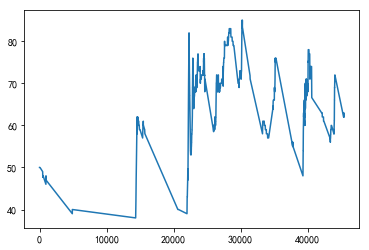

In [34]:
new_df["液压油温"].plot()

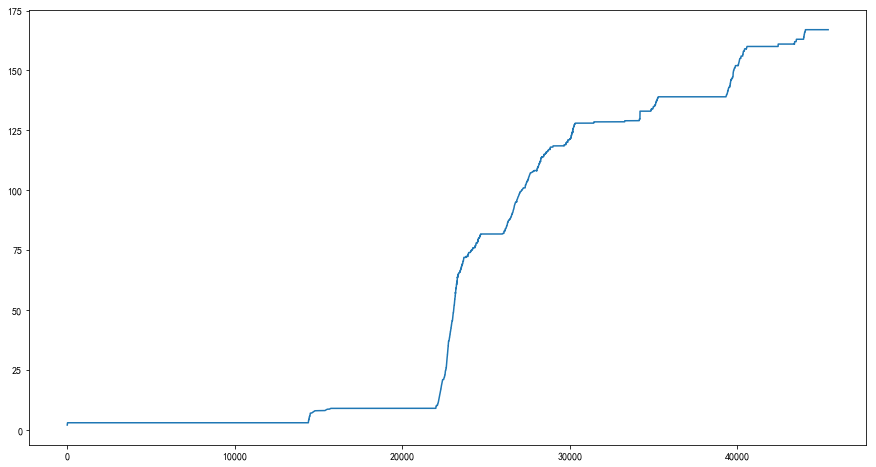

In [82]:
new_df["累计油耗"].plot()

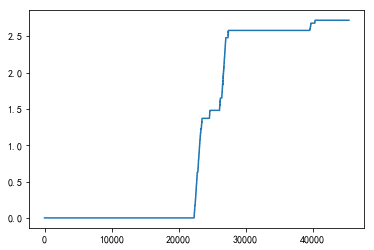

In [36]:
new_df["累计时间"].plot()

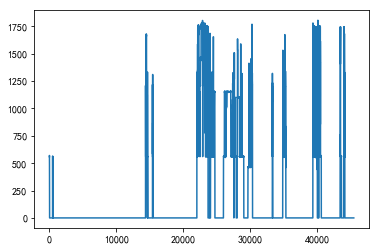

In [37]:
new_df["发动机转速"].plot()

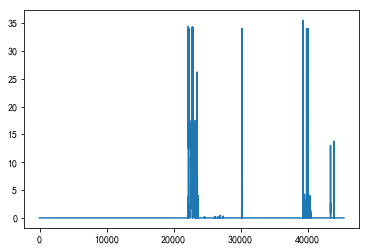

In [38]:
new_df["系统压力"].plot()

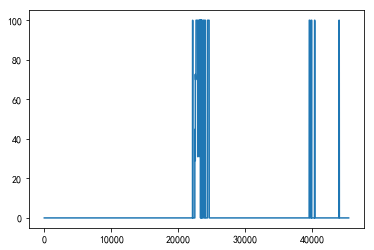

In [39]:
new_df["泵送排量"].plot()

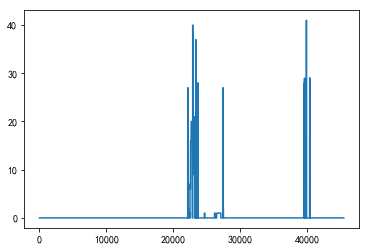

In [40]:
new_df["转向次数"].plot()

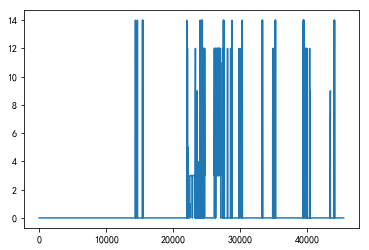

In [41]:
new_df["泵车状态"].plot()

# 过程划分

In [42]:
##

In [43]:
def count_cut(df,col,t): ######间隔t个行视为分割开的次数
    df.loc[df[col]>0,"col_diff"] = df.loc[df[col]>0,"index"] - df.loc[df[col]>0,"index"].shift(1)
    df.loc[df[col]>0,"count_flag"] =df.loc[df[col]>0,"col_diff"].apply(lambda x: 1 if x>t else 0)
    df.loc[df[col]>0,col+"count"] =df.loc[df[col]>0,"count_flag"].cumsum()
    df = df.drop(["col_diff","count_flag"],axis=1)
    return df

In [44]:
new_df = count_cut(new_df,"转向次数",360)

In [45]:
new_df[new_df["转向次数count"]==1]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count
24600,24600,1.564372e+09,74.172414,0.0,80.238718,0.344828,1149.103448,0.000000,1.370690,12.0,2019-07-29 11:41:59,1.564372e+09,40.0,1.0
24601,24601,1.564372e+09,74.586207,0.0,80.157556,0.344828,1149.103448,0.000000,1.370000,12.0,2019-07-29 11:42:04,NaN,10.0,1.0
24606,24606,1.564372e+09,74.000000,0.0,80.260450,0.200000,1149.200000,0.000000,1.370000,12.0,2019-07-29 11:42:29,1.564372e+09,5.0,1.0
24607,24607,1.564372e+09,74.000000,0.0,80.291961,1.000000,1150.200000,0.000000,1.370000,12.0,2019-07-29 11:42:34,1.564372e+09,5.0,1.0
24608,24608,1.564372e+09,74.000000,0.0,80.319132,1.000000,1149.500000,0.000000,1.372500,12.0,2019-07-29 11:42:39,1.564372e+09,5.0,1.0
24609,24609,1.564372e+09,73.000000,0.0,80.337621,1.000000,1151.000000,0.000000,1.380000,12.0,2019-07-29 11:42:44,1.564372e+09,5.0,1.0
24610,24610,1.564372e+09,72.907407,0.0,80.478474,1.000000,1151.000000,0.000000,1.383333,12.0,2019-07-29 11:42:49,NaN,15.0,1.0
24611,24611,1.564372e+09,72.814815,0.0,80.478474,1.000000,1151.000000,0.000000,1.383333,12.0,2019-07-29 11:42:54,NaN,15.0,1.0
24612,24612,1.564372e+09,72.722222,0.0,80.478474,1.000000,1149.888889,0.027778,1.383333,12.0,2019-07-29 11:42:59,1.564372e+09,15.0,1.0
24613,24613,1.564372e+09,72.861111,0.0,80.357717,1.000000,1149.888889,0.027778,1.380000,12.0,2019-07-29 11:43:04,NaN,10.0,1.0


In [46]:
new_df.loc[new_df["泵送排量"]>0,"col_diff"] = new_df.loc[new_df["泵送排量"]>0,"index"] - new_df.loc[new_df["泵送排量"]>0,"index"].shift(1)

In [47]:
new_df.loc[new_df["泵送排量"]>0,"count_flag"] =new_df.loc[new_df["泵送排量"]>0,"col_diff"].apply(lambda x: 1 if x>100 else 0)

In [48]:
new_df.loc[new_df["泵送排量"]>0,"count"] =new_df.loc[new_df["泵送排量"]>0,"count_flag"].cumsum()

In [49]:
new_df[new_df["泵送排量"]>0]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count_flag,count
22130,22130,1.564359e+09,49.000000,80.000000,11.029126,2.000000,1319.800000,0.600000,0.00,3.0,2019-07-29 08:16:09,1.564359e+09,25.0,0.0,NaN,0.0,0.0
22131,22131,1.564359e+09,49.666667,80.000000,11.067961,10.000000,1442.333333,1.333333,0.00,3.0,2019-07-29 08:16:14,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22132,22132,1.564359e+09,49.000000,95.000000,11.101942,16.750000,1517.500000,1.750000,0.00,3.0,2019-07-29 08:16:19,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22133,22133,1.564359e+09,48.100000,100.000000,11.145631,24.600000,1624.400000,2.800000,0.00,3.0,2019-07-29 08:16:24,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22134,22134,1.564359e+09,47.750000,100.000000,11.189320,26.000000,1677.250000,2.250000,0.00,3.0,2019-07-29 08:16:29,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22135,22135,1.564359e+09,47.000000,100.000000,11.228155,26.750000,1703.750000,3.750000,0.00,3.0,2019-07-29 08:16:34,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22136,22136,1.564359e+09,47.000000,100.000000,11.276699,27.000000,1730.333333,2.166667,0.00,3.0,2019-07-29 08:16:39,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22137,22137,1.564359e+09,47.000000,100.000000,11.320388,9.333333,1473.333333,0.666667,0.00,4.0,2019-07-29 08:16:44,1.564359e+09,5.0,0.0,1.0,0.0,0.0
22138,22138,1.564359e+09,47.000000,100.000000,11.349515,9.333333,1473.333333,0.666667,0.00,4.0,2019-07-29 08:16:49,NaN,25.0,0.0,1.0,0.0,0.0
22139,22139,1.564359e+09,47.000000,100.000000,11.349515,9.333333,1473.333333,0.666667,0.00,4.0,2019-07-29 08:16:54,NaN,25.0,0.0,1.0,0.0,0.0


# 划分开始

In [50]:
###系统憋压

In [51]:
new_df[(new_df["泵车状态"] == 10)]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count_flag,count


In [350]:
####退活塞,需不需要考虑退活塞保持？？？？code9

In [52]:
t=120
ths = new_df[(new_df["泵车状态"] == 7)]
ths["idx_diff"] = ths["index"] - ths["index"].shift(1)
ths["count_flag"] =ths["idx_diff"].apply(lambda x: 1 if x>t else 0)
ths["退活塞_count"] =ths["count_flag"].cumsum()
ths  = ths.drop(["idx_diff","count_flag"],axis=1)
ths

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count,退活塞_count
23352,23352,1.564365e+09,69.133333,100.0,65.173712,0.0,716.200000,0.000000,1.23,7.0,2019-07-29 09:57:59,1.564365e+09,15.0,NaN,1.0,1.0,0
23353,23353,1.564365e+09,69.066667,100.0,65.062167,0.0,716.200000,0.000000,1.23,7.0,2019-07-29 09:58:04,NaN,10.0,NaN,1.0,1.0,0
23361,23361,1.564366e+09,70.000000,100.0,65.287744,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:44,1.564366e+09,5.0,NaN,1.0,1.0,0
23362,23362,1.564366e+09,70.245614,100.0,65.426568,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:49,NaN,15.0,NaN,1.0,1.0,0
23363,23363,1.564366e+09,70.491228,100.0,65.426568,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:54,NaN,15.0,NaN,1.0,1.0,0
23364,23364,1.564366e+09,70.736842,100.0,65.426568,0.0,1744.105263,0.000000,1.23,7.0,2019-07-29 09:58:59,1.564366e+09,15.0,NaN,1.0,1.0,0
23365,23365,1.564366e+09,70.368421,100.0,65.319716,0.0,1744.105263,0.000000,1.23,7.0,2019-07-29 09:59:04,NaN,10.0,NaN,1.0,1.0,0
23366,23366,1.564366e+09,70.000000,100.0,65.319716,0.0,1745.000000,0.000000,1.23,7.0,2019-07-29 09:59:09,1.564366e+09,10.0,NaN,1.0,1.0,0
23367,23367,1.564366e+09,70.000000,100.0,65.346359,0.0,1743.333333,0.000000,1.23,7.0,2019-07-29 09:59:14,1.564366e+09,5.0,NaN,1.0,1.0,0
23368,23368,1.564366e+09,70.666667,100.0,65.378330,0.0,1744.333333,0.000000,1.23,7.0,2019-07-29 09:59:19,1.564366e+09,5.0,NaN,1.0,1.0,0


In [53]:
ths

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count,退活塞_count
23352,23352,1.564365e+09,69.133333,100.0,65.173712,0.0,716.200000,0.000000,1.23,7.0,2019-07-29 09:57:59,1.564365e+09,15.0,NaN,1.0,1.0,0
23353,23353,1.564365e+09,69.066667,100.0,65.062167,0.0,716.200000,0.000000,1.23,7.0,2019-07-29 09:58:04,NaN,10.0,NaN,1.0,1.0,0
23361,23361,1.564366e+09,70.000000,100.0,65.287744,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:44,1.564366e+09,5.0,NaN,1.0,1.0,0
23362,23362,1.564366e+09,70.245614,100.0,65.426568,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:49,NaN,15.0,NaN,1.0,1.0,0
23363,23363,1.564366e+09,70.491228,100.0,65.426568,0.0,1307.000000,0.000000,1.23,7.0,2019-07-29 09:58:54,NaN,15.0,NaN,1.0,1.0,0
23364,23364,1.564366e+09,70.736842,100.0,65.426568,0.0,1744.105263,0.000000,1.23,7.0,2019-07-29 09:58:59,1.564366e+09,15.0,NaN,1.0,1.0,0
23365,23365,1.564366e+09,70.368421,100.0,65.319716,0.0,1744.105263,0.000000,1.23,7.0,2019-07-29 09:59:04,NaN,10.0,NaN,1.0,1.0,0
23366,23366,1.564366e+09,70.000000,100.0,65.319716,0.0,1745.000000,0.000000,1.23,7.0,2019-07-29 09:59:09,1.564366e+09,10.0,NaN,1.0,1.0,0
23367,23367,1.564366e+09,70.000000,100.0,65.346359,0.0,1743.333333,0.000000,1.23,7.0,2019-07-29 09:59:14,1.564366e+09,5.0,NaN,1.0,1.0,0
23368,23368,1.564366e+09,70.666667,100.0,65.378330,0.0,1744.333333,0.000000,1.23,7.0,2019-07-29 09:59:19,1.564366e+09,5.0,NaN,1.0,1.0,0


In [353]:
####高低压打泵,5+5+10，各20min，约240个时间单位

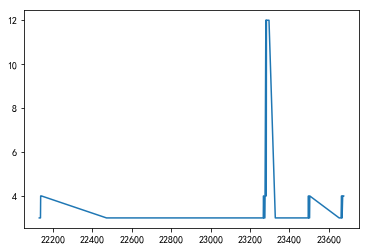

In [354]:
new_df[(new_df["转向次数"]>0) & (new_df["泵送排量"]>0)&(new_df["系统压力"]>0)&(new_df["转向次数count"]==0)]["泵车状态"].plot()

In [54]:

tmp_bengsong =new_df[(new_df["转向次数"]>0) & (new_df["泵送排量"]>0)&(new_df["系统压力"]>0)&((new_df["转向次数count"]==0) | (new_df["转向次数count"]==1))&(new_df["泵车状态"] == 3)]
idx_start = tmp_bengsong.iloc[0]["index"]
idx_end = tmp_bengsong.iloc[-1]["index"]

In [55]:
tmp_bs = new_df.loc[idx_start:idx_end]

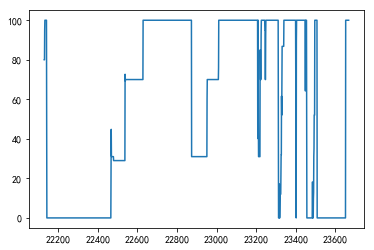

In [56]:
tmp_bs["泵送排量"].plot()

In [57]:
tmp_bs["泵送排量_diff"] = tmp_bs["泵送排量"] - tmp_bs["泵送排量"].shift(4)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
####泵送排量陡增30以上，应该为30-70阶段，往回倒退10分钟视作打泵开始
bs_start_idx = tmp_bs[tmp_bs["泵送排量_diff"]>30].iloc[0]["index"] - 120

In [59]:
tmp_bs = new_df.loc[bs_start_idx:idx_end]
tmp_bs["泵送排量_diff"] = tmp_bs["泵送排量"] - tmp_bs["泵送排量"].shift(4)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


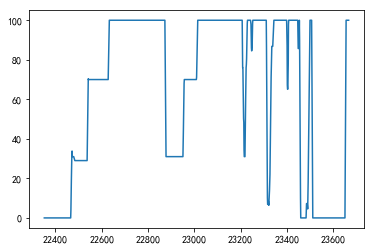

In [60]:
tmp_bs["泵送排量"].rolling(5).mean().plot()

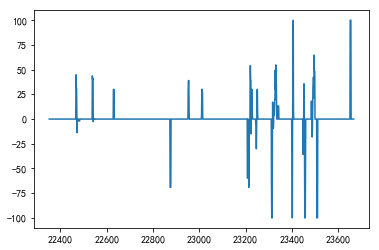

In [61]:
tmp_bs["泵送排量_diff"].plot()

In [62]:
tmp_bs_end = tmp_bs[tmp_bs["泵送排量_diff"]<-55]
t= 60
tmp_bs_end["idx_diff"] = tmp_bs_end["index"] - tmp_bs_end["index"].shift(1)
tmp_bs_end["count_flag"] =tmp_bs_end["idx_diff"].apply(lambda x: 1 if x>t else 0)
tmp_bs_end["泵送结束_count"] =tmp_bs_end["count_flag"].cumsum()
tmp_bs_end  = tmp_bs_end.drop(["idx_diff","count_flag"],axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [63]:
tmp_bs_end

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count,泵送排量_diff,泵送结束_count
22874,22874,1.564363e+09,76.000000,31.000000,40.917184,40.0,1246.750000,1.0,0.630000,3.0,2019-07-29 09:18:09,1.564363e+09,25.0,0.0,1.0,1.0,-69.000000,0
22875,22875,1.564363e+09,75.000000,31.000000,40.975155,40.0,1228.666667,1.0,0.630000,3.0,2019-07-29 09:18:14,1.564363e+09,5.0,0.0,1.0,1.0,-69.000000,0
22876,22876,1.564363e+09,75.000000,31.000000,41.033126,38.0,1221.750000,1.0,0.630000,3.0,2019-07-29 09:18:19,1.564363e+09,5.0,0.0,1.0,1.0,-69.000000,0
22877,22877,1.564363e+09,74.600000,31.000000,41.107660,38.0,1217.000000,1.0,0.630000,3.0,2019-07-29 09:18:24,1.564363e+09,5.0,0.0,1.0,1.0,-69.000000,0
23208,23208,1.564365e+09,69.000000,40.200000,59.193939,12.0,1368.133333,4.4,1.080000,3.0,2019-07-29 09:45:59,1.564365e+09,15.0,0.0,1.0,1.0,-59.800000,1
23209,23209,1.564365e+09,69.000000,40.200000,59.000000,12.0,1368.133333,4.4,1.080000,3.0,2019-07-29 09:46:04,NaN,10.0,0.0,1.0,1.0,-59.800000,1
23214,23214,1.564365e+09,69.000000,31.000000,59.098182,11.4,1274.800000,2.0,1.080000,3.0,2019-07-29 09:46:29,1.564365e+09,5.0,0.0,1.0,1.0,-69.000000,1
23312,23312,1.564365e+09,71.000000,33.833333,64.000000,0.0,707.333333,0.0,1.180000,3.0,2019-07-29 09:54:39,1.564365e+09,5.0,NaN,1.0,1.0,-66.166667,2
23313,23313,1.564365e+09,71.000000,0.000000,64.000000,0.0,1126.333333,0.0,1.180000,3.0,2019-07-29 09:54:44,1.564365e+09,5.0,NaN,NaN,NaN,-100.000000,2
23314,23314,1.564365e+09,70.722222,0.000000,64.090201,0.0,1126.333333,0.0,1.189167,3.0,2019-07-29 09:54:49,NaN,15.0,NaN,NaN,NaN,-100.000000,2


In [64]:
bs_end1 = tmp_bs_end[tmp_bs_end["泵送结束_count"]==0].iloc[0]["index"]
bs_end2 = tmp_bs_end[tmp_bs_end["泵送结束_count"]==1].iloc[0]["index"]
ba_start2 = max(bs_end2-550,bs_end1)

In [65]:
tmp_bs1 = new_df.loc[bs_start_idx:bs_end1]
tmp_bs2 = new_df.loc[ba_start2:bs_end2]

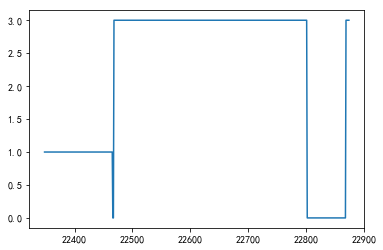

In [66]:
tmp_bs1["泵车状态"].plot()

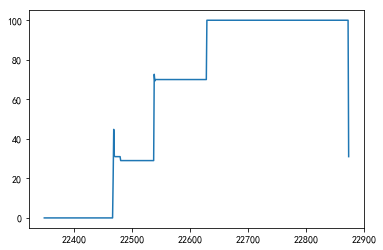

In [67]:
tmp_bs1["泵送排量"].plot()

In [77]:
####泵送时间bs1
t_bs1_30 = len(tmp_bs1[(tmp_bs1["泵送排量"]>28)&(tmp_bs1["泵送排量"]<32)])*5/60
t_bs1_70 =len(tmp_bs1[(tmp_bs1["泵送排量"]>68)&(tmp_bs1["泵送排量"]<72)])*5/60
t_bs1_100 =len(tmp_bs1[(tmp_bs1["泵送排量"]>98)])*5/60
t_bs1_30,t_bs1_70,t_bs1_100

(5.833333333333333, 7.5, 20.416666666666668)

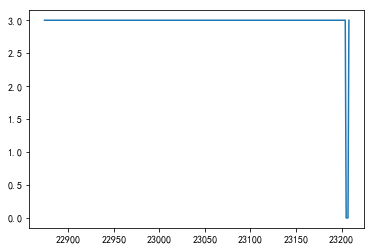

In [68]:
tmp_bs2["泵车状态"].plot()

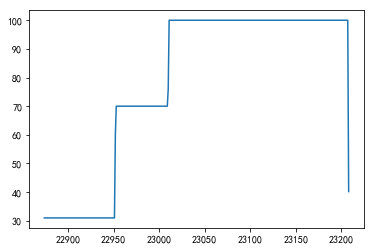

In [69]:
tmp_bs2["泵送排量"].plot()

In [78]:
####泵送时间bs2
t_bs2_30 = len(tmp_bs2[(tmp_bs2["泵送排量"]>28)&(tmp_bs2["泵送排量"]<32)])*5/60
t_bs2_70 =len(tmp_bs2[(tmp_bs2["泵送排量"]>68)&(tmp_bs2["泵送排量"]<72)])*5/60
t_bs2_100 =len(tmp_bs2[(tmp_bs2["泵送排量"]>98)])*5/60
t_bs2_30,t_bs2_70,t_bs2_100

(6.5, 4.75, 16.416666666666668)

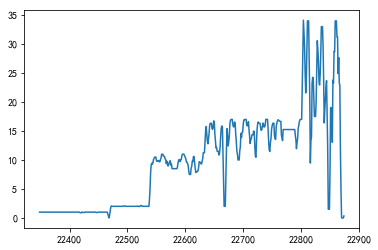

In [371]:
tmp_bs1["系统压力"].rolling(3,min_periods =1).mean().plot()

In [376]:
tmp_bs1[tmp_bs1["系统压力"]>0]["系统压力"].mean()

9.965077829971452

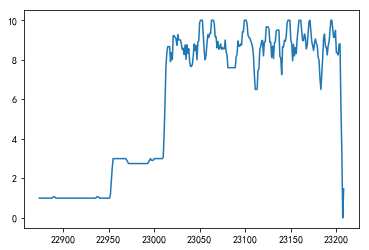

In [372]:
tmp_bs2["系统压力"].rolling(3,min_periods =1).mean().plot()

In [375]:
tmp_bs2[tmp_bs2["系统压力"]>0]["系统压力"].mean()

5.8731612725411475

In [ ]:
####支腿臂架调试

In [373]:
new_df[(new_df["泵车状态"] == 14)|(new_df["泵车状态"] == 12)]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count_flag,count
14344,14344,1.564320e+09,38.000000,0.0,3.000000,0.0,1206.000000,0.0,0.00,14.0,2019-07-28 21:27:19,1.564320e+09,47260.0,NaN,NaN,NaN,NaN
14345,14345,1.564320e+09,38.333333,0.0,3.000000,0.0,1207.666667,0.0,0.00,14.0,2019-07-28 21:27:24,1.564320e+09,5.0,NaN,NaN,NaN,NaN
14346,14346,1.564320e+09,39.000000,0.0,3.000000,0.0,1144.000000,0.0,0.00,14.0,2019-07-28 21:27:29,1.564320e+09,5.0,NaN,NaN,NaN,NaN
14380,14380,1.564321e+09,41.000000,0.0,3.000000,0.0,1621.666667,0.0,0.00,12.0,2019-07-28 21:30:19,1.564321e+09,90.0,NaN,NaN,NaN,NaN
14381,14381,1.564321e+09,41.000000,0.0,3.000000,0.0,1645.666667,0.0,0.00,12.0,2019-07-28 21:30:24,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14382,14382,1.564321e+09,41.555556,0.0,3.000000,0.0,1614.333333,0.0,0.00,12.0,2019-07-28 21:30:29,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14383,14383,1.564321e+09,42.000000,0.0,3.000000,0.0,1572.333333,0.0,0.00,12.0,2019-07-28 21:30:34,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14384,14384,1.564321e+09,42.000000,0.0,3.000000,0.0,1539.000000,0.0,0.00,12.0,2019-07-28 21:30:39,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14385,14385,1.564321e+09,42.250000,0.0,3.000000,0.0,1536.250000,0.0,0.00,12.0,2019-07-28 21:30:44,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14386,14386,1.564321e+09,42.500000,0.0,3.000000,0.0,1536.250000,0.0,0.00,12.0,2019-07-28 21:30:49,NaN,35.0,NaN,NaN,NaN,NaN


In [87]:
###支腿动作

In [88]:
zt_start = new_df[(new_df["泵车状态"] == 14)].iloc[0]["index"]

In [89]:
zt_tmp = new_df.loc[zt_start:idx_start]
zt_diff = zt_tmp["泵车状态"] - zt_tmp["泵车状态"].shift(1)
len(zt_diff[zt_diff==-14])

7

按理来说，应该有6（支腿调试）+1次（臂架收起）次

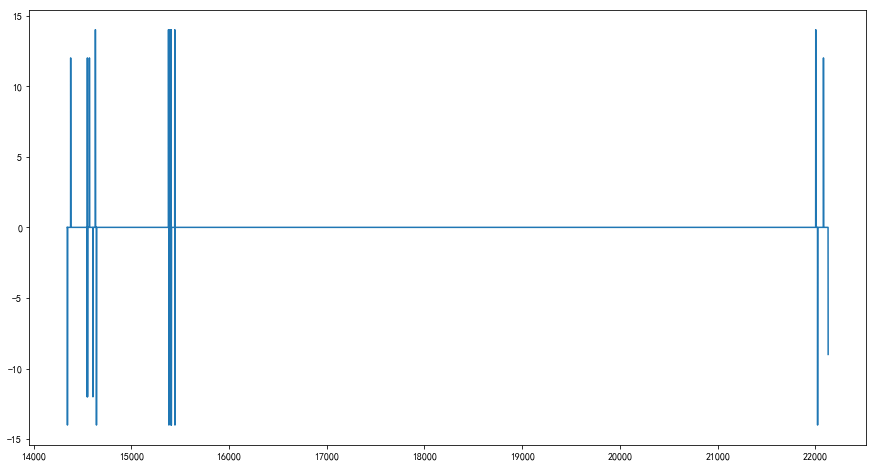

In [91]:
zt_diff.plot()

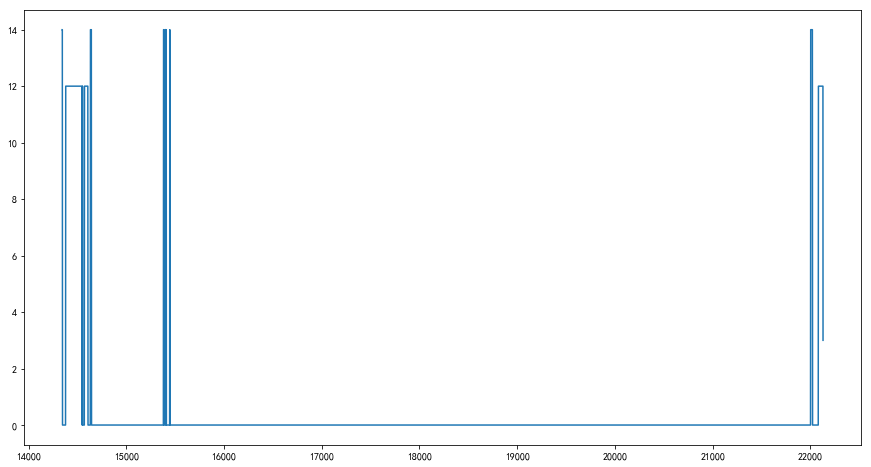

In [92]:
new_df.loc[zt_start:idx_start]["泵车状态"].plot()

In [ ]:
####臂架动作

In [101]:
bj_start = new_df[(new_df["泵车状态"] == 12)].iloc[0]["index"]
bj_tmp = new_df.loc[bj_start:idx_start]

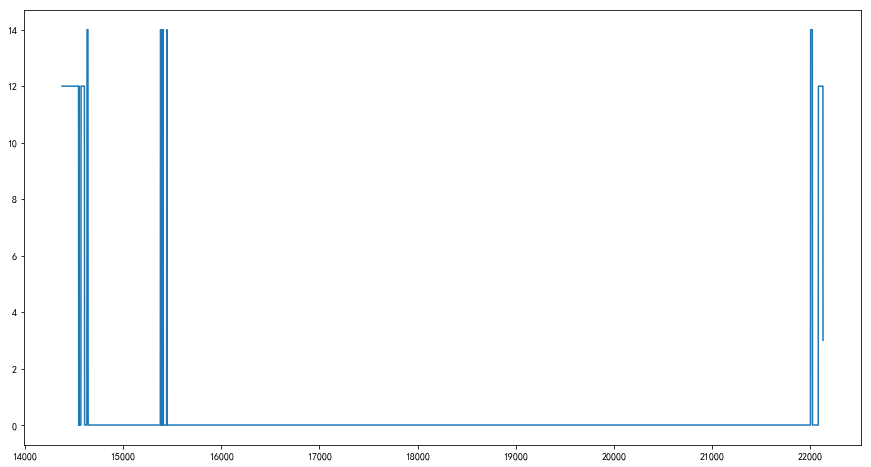

In [109]:
bj_tmp["泵车状态"].plot()

In [106]:
####统计次数，持续时间
###非12状态一并视作其他状态。检测3min时间内12状态的概率，大于0.8视作这三分钟内一直为状态12

bj_tmp["is_stat12"] = bj_tmp["泵车状态"].apply(lambda x: 1 if x==12 else 0)
bj_tmp["stat_mean"] = bj_tmp["is_stat12"].rolling(36,min_periods=12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
bj_tmp["bool_continue"] = bj_tmp["stat_mean"].apply(lambda x: 1 if x>0.8 else 0)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


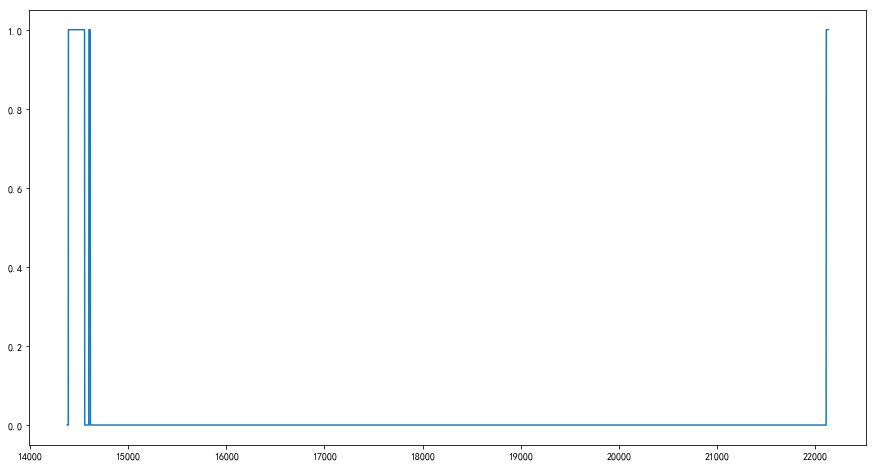

In [117]:
bj_tmp["bool_continue"].plot()

In [114]:
bj_tmp["bool_continue_diff"] = bj_tmp["bool_continue"] - bj_tmp["bool_continue"].shift(1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


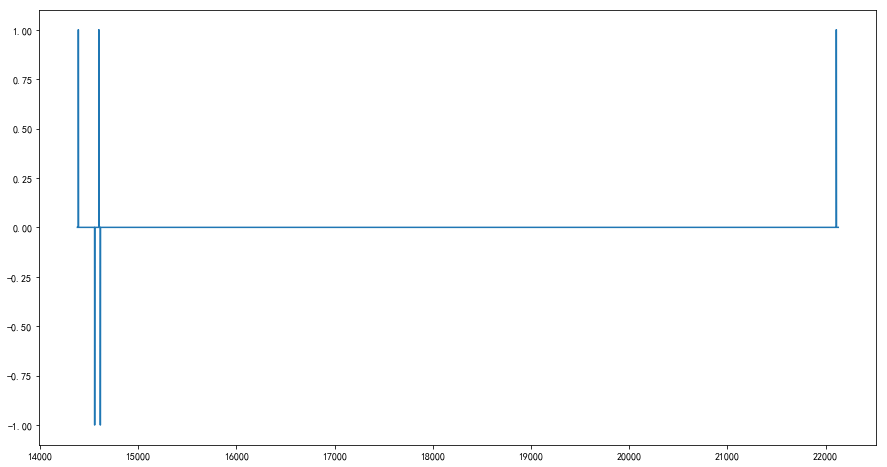

In [116]:
bj_tmp["bool_continue_diff"].plot()

In [119]:
cut_count = len(bj_tmp[bj_tmp["bool_continue_diff"]==-1])
open_count = len(bj_tmp[bj_tmp["bool_continue_diff"]== 1])
##断开次数，第一次是由于没有数据，要忽略

In [121]:
start_idx = {}  ####用字典记录每一次长时间12的起止点
cut_idx = {}
last_t = {}
long_process = {}
for i in range(cut_count):
    start_idx[i] = bj_tmp[bj_tmp["bool_continue_diff"]==1].iloc[i]["index"]
    cut_idx[i] = bj_tmp[bj_tmp["bool_continue_diff"]==-1].iloc[i]["index"]
    last_t[i] = cut_idx[i] - start_idx[i]
    if last_t[i]>60:
        long_process[i] = (start_idx[i],cut_idx[i])

In [122]:
long_process

{0: (14391, 14557)}

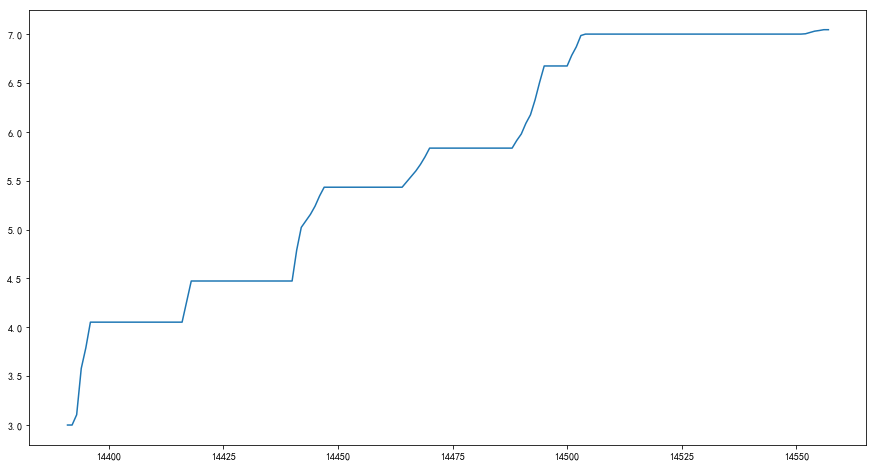

In [126]:
bj_tmp.loc[14391: 14557]["累计油耗"].plot()

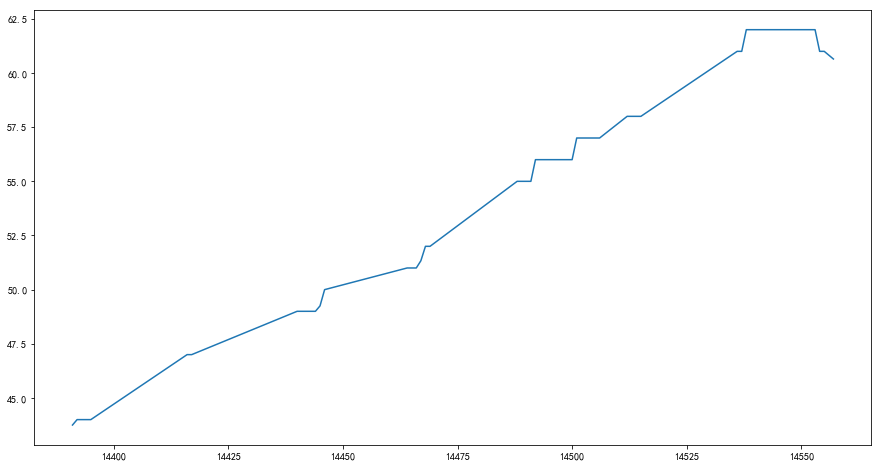

In [124]:
bj_tmp.loc[14391: 14557]["液压油温"].plot()

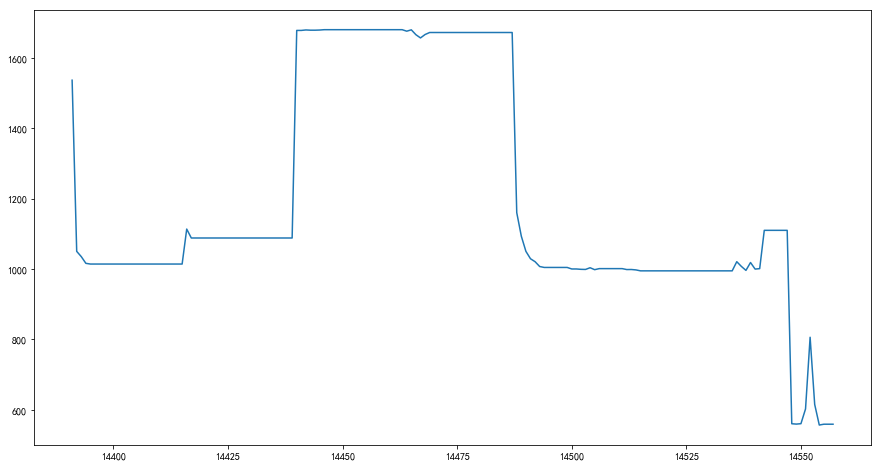

In [125]:
bj_tmp.loc[14391: 14557]["发动机转速"].plot()

In [110]:
bj_tmp[bj_tmp["stat_mean"]>0.8]["index"]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count_flag,count,is_stat12,stat_mean
14391,14391,1.564321e+09,43.750000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:31:14,NaN,35.0,NaN,NaN,NaN,NaN,1,1.000000
14392,14392,1.564321e+09,44.000000,0.0,3.000000,0.0,1050.000000,0.0,0.0,12.0,2019-07-28 21:31:19,1.564321e+09,35.0,NaN,NaN,NaN,NaN,1,1.000000
14393,14393,1.564321e+09,44.000000,0.0,3.105263,0.0,1035.000000,0.0,0.0,12.0,2019-07-28 21:31:24,1.564321e+09,5.0,NaN,NaN,NaN,NaN,1,1.000000
14394,14394,1.564321e+09,44.000000,0.0,3.578947,0.0,1016.000000,0.0,0.0,12.0,2019-07-28 21:31:29,1.564321e+09,5.0,NaN,NaN,NaN,NaN,1,1.000000
14395,14395,1.564321e+09,44.000000,0.0,3.789474,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:34,1.564321e+09,5.0,NaN,NaN,NaN,NaN,1,1.000000
14396,14396,1.564321e+09,44.142857,0.0,4.052632,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:39,NaN,105.0,NaN,NaN,NaN,NaN,1,1.000000
14397,14397,1.564321e+09,44.285714,0.0,4.052632,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:44,NaN,105.0,NaN,NaN,NaN,NaN,1,1.000000
14398,14398,1.564321e+09,44.428571,0.0,4.052632,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:49,NaN,105.0,NaN,NaN,NaN,NaN,1,1.000000
14399,14399,1.564321e+09,44.571429,0.0,4.052632,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:54,NaN,105.0,NaN,NaN,NaN,NaN,1,1.000000
14400,14400,1.564321e+09,44.714286,0.0,4.052632,0.0,1014.000000,0.0,0.0,12.0,2019-07-28 21:31:59,NaN,105.0,NaN,NaN,NaN,NaN,1,1.000000


In [103]:
bj_tmp

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff,转向次数count,col_diff,count_flag,count
14380,14380,1.564321e+09,41.000000,0.0,3.000000,0.0,1621.666667,0.0,0.0,12.0,2019-07-28 21:30:19,1.564321e+09,90.0,NaN,NaN,NaN,NaN
14381,14381,1.564321e+09,41.000000,0.0,3.000000,0.0,1645.666667,0.0,0.0,12.0,2019-07-28 21:30:24,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14382,14382,1.564321e+09,41.555556,0.0,3.000000,0.0,1614.333333,0.0,0.0,12.0,2019-07-28 21:30:29,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14383,14383,1.564321e+09,42.000000,0.0,3.000000,0.0,1572.333333,0.0,0.0,12.0,2019-07-28 21:30:34,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14384,14384,1.564321e+09,42.000000,0.0,3.000000,0.0,1539.000000,0.0,0.0,12.0,2019-07-28 21:30:39,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14385,14385,1.564321e+09,42.250000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:30:44,1.564321e+09,5.0,NaN,NaN,NaN,NaN
14386,14386,1.564321e+09,42.500000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:30:49,NaN,35.0,NaN,NaN,NaN,NaN
14387,14387,1.564321e+09,42.750000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:30:54,NaN,35.0,NaN,NaN,NaN,NaN
14388,14388,1.564321e+09,43.000000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:30:59,NaN,35.0,NaN,NaN,NaN,NaN
14389,14389,1.564321e+09,43.250000,0.0,3.000000,0.0,1536.250000,0.0,0.0,12.0,2019-07-28 21:31:04,NaN,35.0,NaN,NaN,NaN,NaN


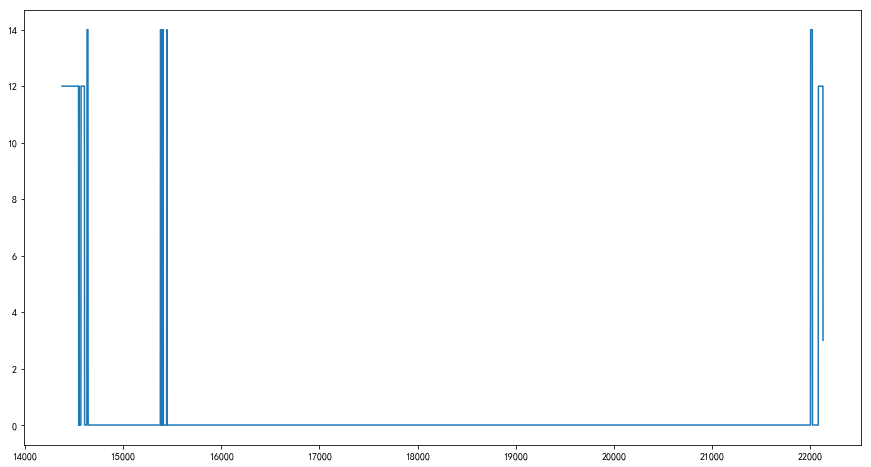

In [102]:
bj_tmp["泵车状态"].plot()

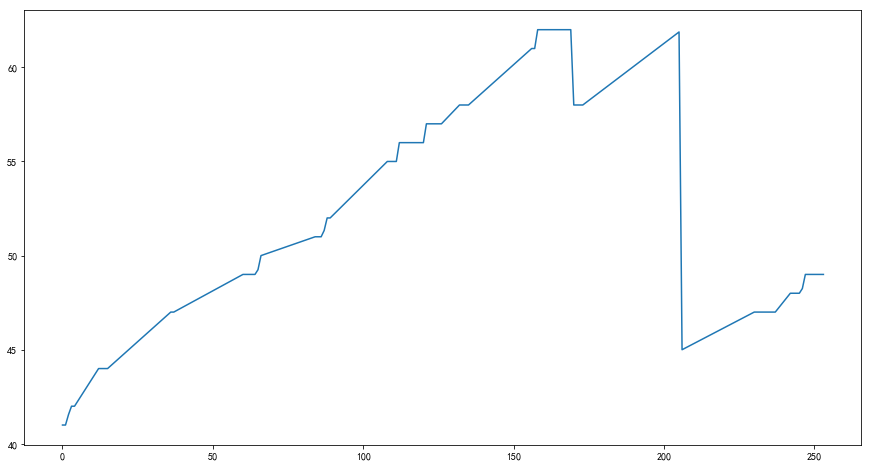

In [95]:
plt.plot(bj_tmp[bj_tmp["发动机转速"]>0].reset_index()["液压油温"])

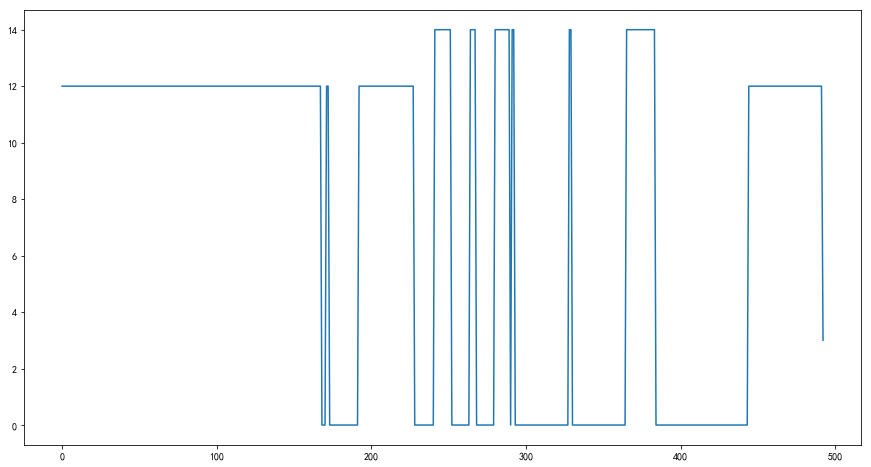

In [127]:
plt.plot(bj_tmp[bj_tmp["发动机转速"]>0].reset_index()["泵车状态"])

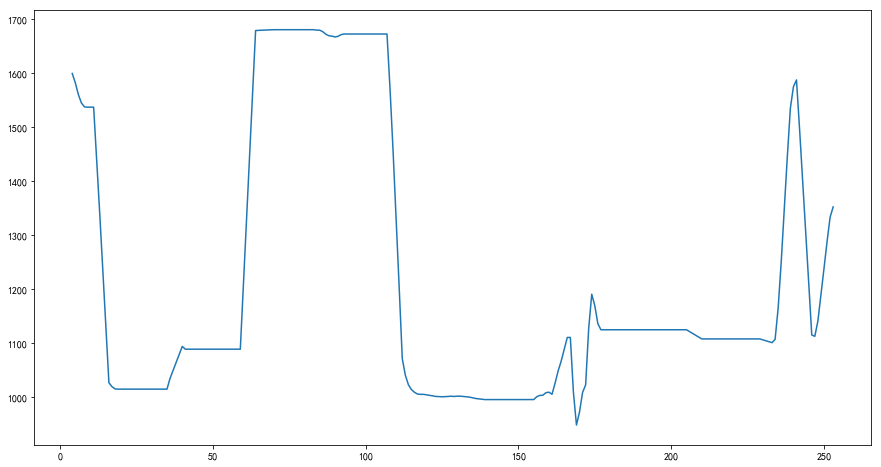

In [97]:
plt.plot(bj_tmp[bj_tmp["发动机转速"]>0].reset_index()["发动机转速"].rolling(5).mean())

#####区分臂架旋转和臂架展开

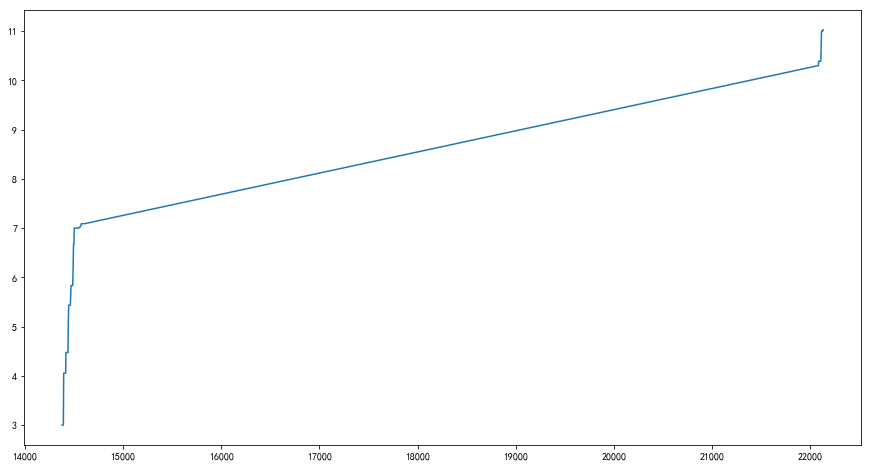

In [98]:
bj_tmp["累计油耗"].plot()

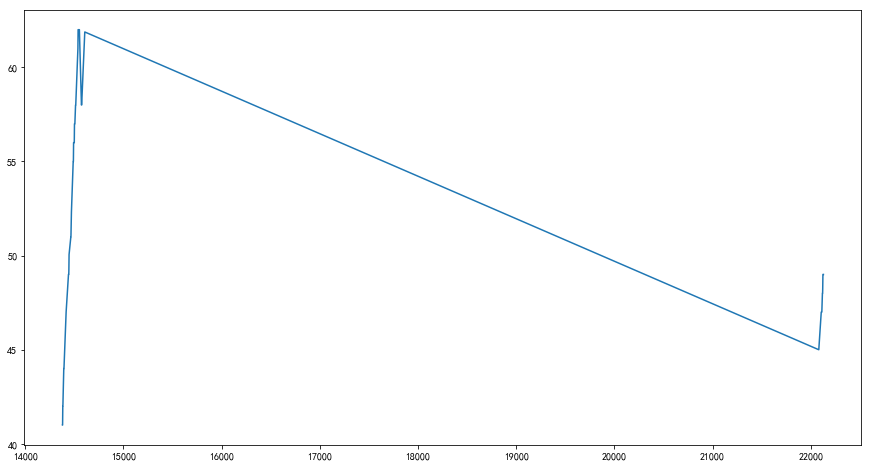

In [99]:
bj_tmp["液压油温"].plot()

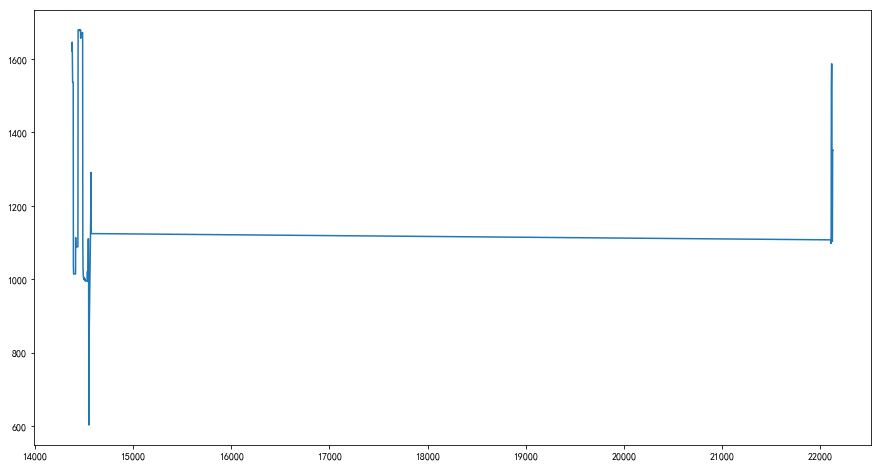

In [100]:
bj_tmp["发动机转速"].plot()

In [53]:
####交检洗车

In [ ]:
###确定泵送完毕时间


In [ ]:
####确定发动机停止和缺失数据
